In [1]:
!pip install folium

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/clean_dataset.parquet'
df_train = pd.read_parquet(train_path)
figures_path = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/docs/figures/'

In [4]:
df_sample = df_train.sample(1000000, random_state=42)

In [5]:
df_train['day_of_week'] = df_train['tpep_pickup_datetime'].dt.dayofweek

df_train['hour'] = df_train['tpep_pickup_datetime'].dt.hour

df_train['day_name'] = df_train['tpep_pickup_datetime'].dt.day_name()

df_train['pickup_date'] = df_train['tpep_pickup_datetime'].dt.date

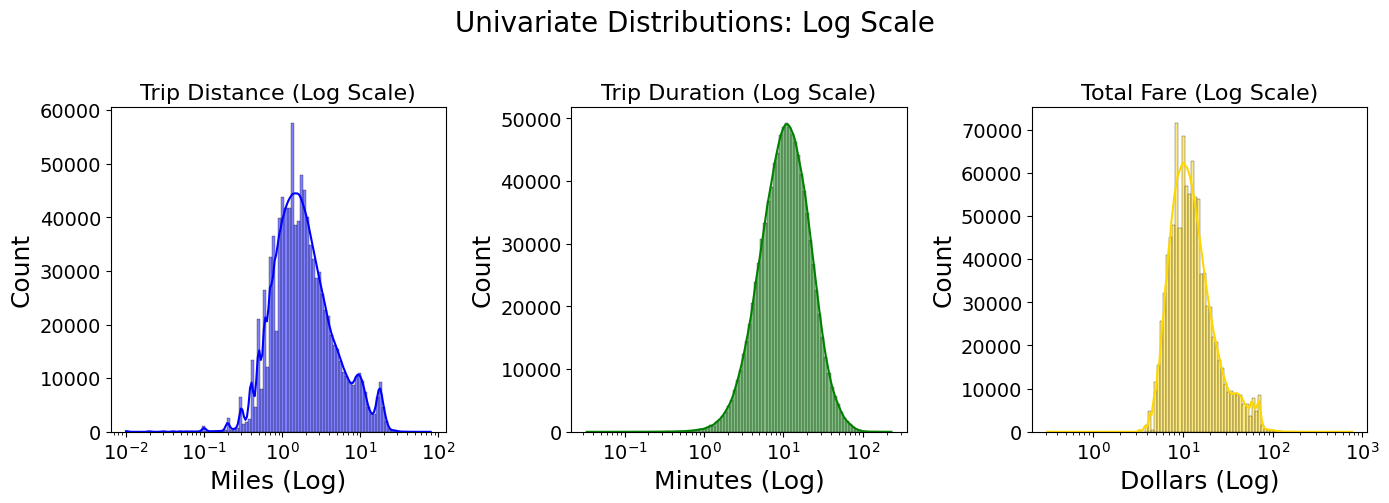

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5.25))

# Trip Distance
sns.histplot(df_sample['trip_distance'], bins=100, kde=True, ax=axes[0], color='blue', log_scale=True)
axes[0].set_title('Trip Distance (Log Scale)', fontsize=16)
axes[0].set_xlabel('Miles (Log)', fontsize=18)
axes[0].set_ylabel('Count', fontsize=18)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)

# Trip Duration
sns.histplot(df_sample['trip_duration_min'], bins=100, kde=True, ax=axes[1], color='green', log_scale=True)
axes[1].set_title('Trip Duration (Log Scale)', fontsize=16)
axes[1].set_xlabel('Minutes (Log)', fontsize=18)
axes[1].set_ylabel('Count', fontsize=18)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

# Total Amount (Fare)
sns.histplot(df_sample['total_amount'], bins=100, kde=True, ax=axes[2], color='gold', log_scale=True)
axes[2].set_title('Total Fare (Log Scale)', fontsize=16)
axes[2].set_xlabel('Dollars (Log)', fontsize=18)
axes[2].set_ylabel('Count', fontsize=18)
axes[2].tick_params(axis='x', labelsize=14)
axes[2].tick_params(axis='y', labelsize=14)

plt.suptitle('Univariate Distributions: Log Scale', fontsize=20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to leave space for suptitle
plt.savefig(os.path.join(figures_path, "univariate_distributions.svg"), format="svg")
plt.show()

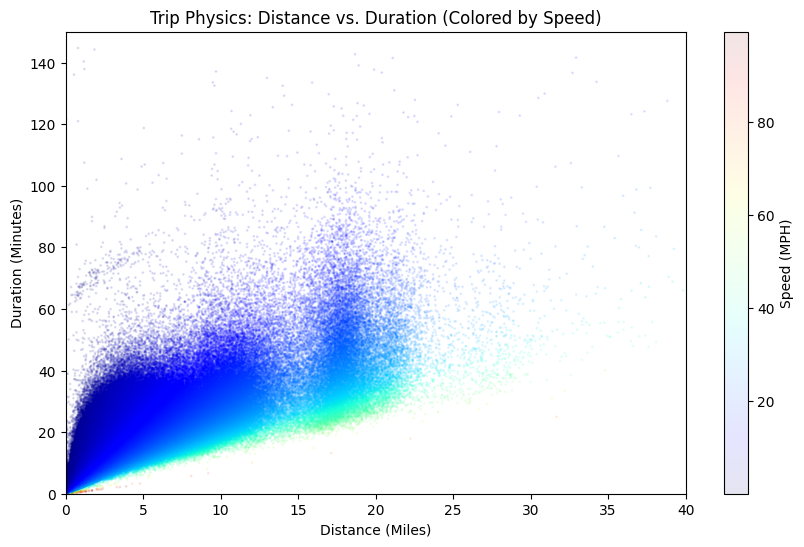

In [7]:
plt.figure(figsize=(10, 6))
# Sample 50k to avoid overplotting
plt.scatter(df_sample['trip_distance'], df_sample['trip_duration_min'],
            alpha=0.1, s=1, c=df_sample['speed_mph'], cmap='jet')

plt.colorbar(label='Speed (MPH)')
plt.xlabel('Distance (Miles)')
plt.ylabel('Duration (Minutes)')
plt.title('Trip Physics: Distance vs. Duration (Colored by Speed)')
plt.xlim(0, 40)
plt.ylim(0, 150)
plt.savefig(os.path.join(figures_path, "trip_physics.png"), dpi=300, bbox_inches='tight')
plt.show()

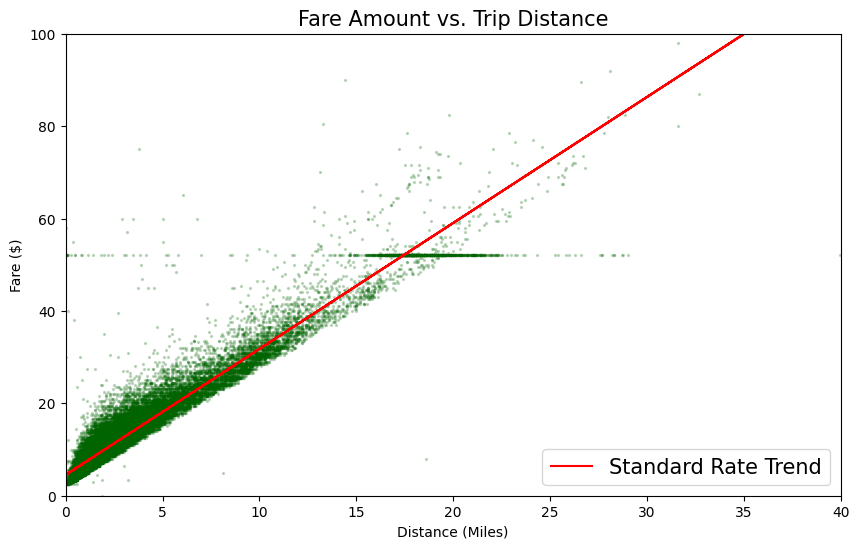

In [8]:
plt.figure(figsize=(10, 6))
# Sample 50k for a clear scatter
scatter_sample = df_sample.sample(50000)

plt.scatter(scatter_sample['trip_distance'], scatter_sample['fare_amount'],
            alpha=0.2, s=2, c='darkgreen')

# Add a trend line
m, b = np.polyfit(scatter_sample['trip_distance'], scatter_sample['fare_amount'], 1)
plt.plot(scatter_sample['trip_distance'], m*scatter_sample['trip_distance'] + b, color='red', label='Standard Rate Trend')

plt.title('Fare Amount vs. Trip Distance', fontsize=15)
plt.xlabel('Distance (Miles)')
plt.ylabel('Fare ($)')
plt.xlim(0, 40)
plt.ylim(0, 100)
plt.legend(fontsize=15)
plt.savefig(os.path.join(figures_path, "fare_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

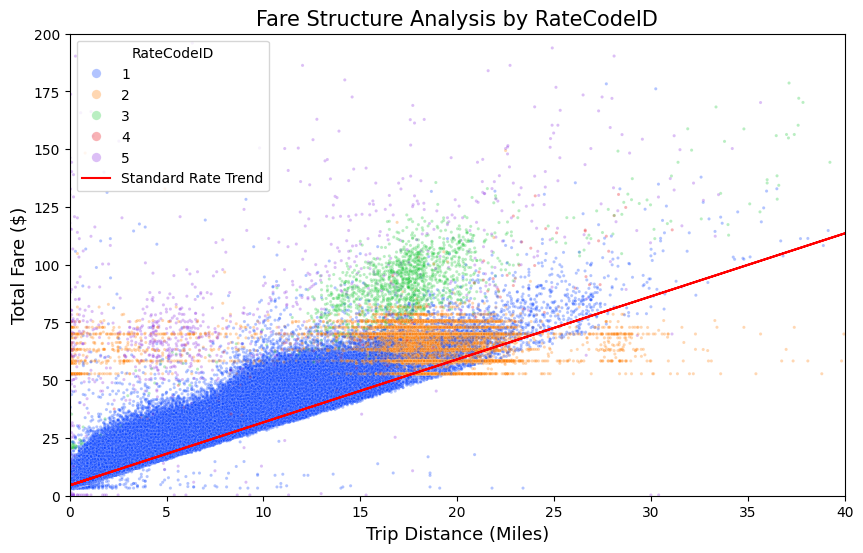

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sample, x='trip_distance', y='total_amount',
                hue='RateCodeID', palette='bright', alpha=0.3, s=5)

# Add a trend line
m, b = np.polyfit(scatter_sample['trip_distance'], scatter_sample['fare_amount'], 1)
plt.plot(scatter_sample['trip_distance'], m*scatter_sample['trip_distance'] + b, color='red', label='Standard Rate Trend')

plt.title('Fare Structure Analysis by RateCodeID', fontsize=15)
plt.xlabel('Trip Distance (Miles)', fontsize=13)
plt.ylabel('Total Fare ($)', fontsize=13)
plt.legend(title='RateCodeID', loc='upper left', markerscale=3)
plt.xlim(0, 40)
plt.ylim(0, 200)
plt.savefig(os.path.join(figures_path, "ratecode_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

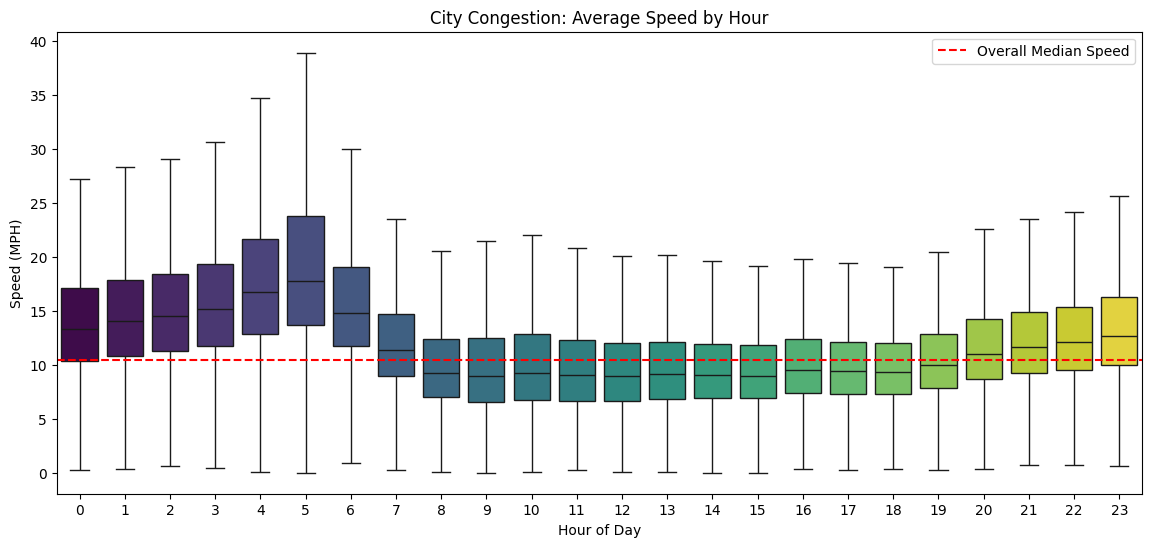

In [10]:
plt.figure(figsize=(14, 6))
df_sample['hour'] = df_sample['tpep_pickup_datetime'].dt.hour # Add this line to create the 'hour' column for df_sample
sns.boxplot(x='hour', y='speed_mph', data=df_sample, showfliers=False, palette='viridis', hue='hour', legend=False)
plt.axhline(df_sample['speed_mph'].median(), color='red', linestyle='--', label='Overall Median Speed')
plt.title('City Congestion: Average Speed by Hour')
plt.ylabel('Speed (MPH)')
plt.xlabel('Hour of Day')
plt.legend()
plt.show()

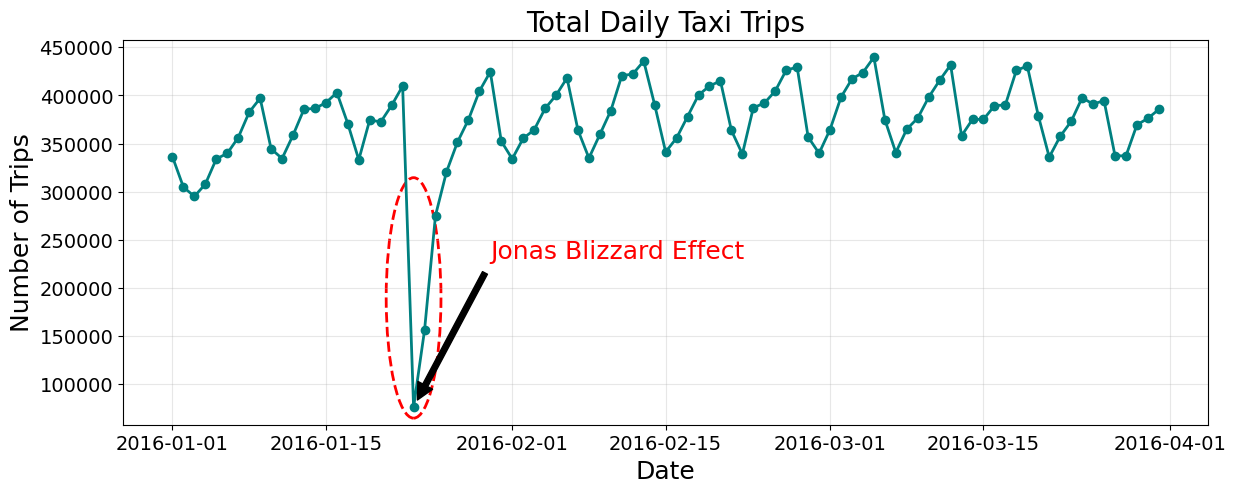

In [11]:
import matplotlib.patches as patches

daily_trips = df_train.groupby('pickup_date').size()

plt.figure(figsize=(14, 5))
ax = daily_trips.plot(kind='line', marker='o', color='teal', linewidth=2)
plt.title('Total Daily Taxi Trips', fontsize=20)
plt.ylabel('Number of Trips', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.grid(True, alpha=0.3)

# Increase tick label sizes
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Find the date for the massive drop
drop_date_str = '2016-01-23'
drop_date_obj = pd.to_datetime(drop_date_str).date()
drop_y = daily_trips.loc[drop_date_obj]

# Add an ellipse to highlight the drop
ellipse_width_days = 5 # Width in days for the x-axis
ellipse_height_trips = 250000 # Height in trip count for the y-axis

ellipse_center_x = drop_date_obj
ellipse_center_y = drop_y + ellipse_height_trips / 2.2 # Adjust vertically to cover the dip
ellipse = patches.Ellipse((ellipse_center_x, ellipse_center_y),
                          width=ellipse_width_days, # Use the numerical value directly
                          height=ellipse_height_trips,
                          edgecolor='red', facecolor='none', linestyle='--', linewidth=2, angle=0)
ax.add_patch(ellipse)

# Add annotation
ax.annotate('Jonas Blizzard Effect',
            xy=(drop_date_obj, drop_y),  # Point to annotate at the dip
            xytext=(pd.to_datetime('2016-01-23') + pd.Timedelta(days=7), drop_y + 150000),  # Text position relative to the point
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom',
            fontsize=18,
            color='red')

plt.savefig(os.path.join(figures_path, "jonas_blizzard.svg"), format="svg", bbox_inches='tight')
plt.show()

In [12]:
daily_trips_df = daily_trips.to_frame(name='trip_count')
daily_trips_df['daily_change'] = daily_trips_df['trip_count'].diff()
daily_trips_df['percentage_change'] = (daily_trips_df['daily_change'] / daily_trips_df['trip_count'].shift(1)) * 100

# Identify dates with a 'massive drop' (e.g., more than 20% decrease from the previous day)
massive_drops = daily_trips_df[daily_trips_df['percentage_change'] < -20]

print("Dates with a massive drop in daily trips (more than 20% decrease):")
for date, row in massive_drops.iterrows():
    print(f"Date: {date.strftime('%Y-%m-%d')}, Trip Count: {int(row['trip_count'])}, Percentage Change: {row['percentage_change']:.2f}%")

del daily_trips_df

Dates with a massive drop in daily trips (more than 20% decrease):
Date: 2016-01-23, Trip Count: 75932, Percentage Change: -81.47%


A massive drop in daily taxi trips was observed on 2016-01-23, with a decrease of 81.47% compared to the previous day, resulting in only 75932 trips.

This significant reduction is attributed to **Winter Storm Jonas (Blizzard of 2016)**, which brought heavy snowfall and hazardous conditions to the East Coast of the United States around that date, severely impacting travel and daily activities in New York City. The blizzard led to widespread cancellations of flights, public transportation shutdowns, and a general advisory for people to stay indoors, directly causing the sharp decline in taxi ridership.

Reference: https://en.wikipedia.org/wiki/January_2016_United_States_blizzard


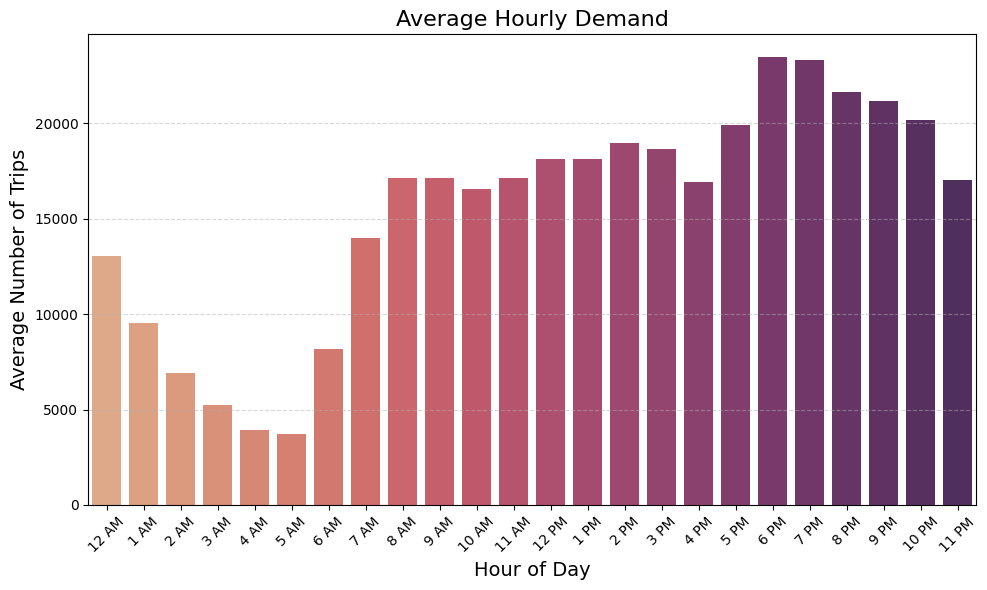

In [13]:
hourly_avg = df_train.groupby('hour').size() / len(df_train['pickup_date'].unique())

# Convert numerical hour to AM/PM format
hour_labels = [f'{h % 12 or 12} AM' if h < 12 else (f'{h % 12 or 12} PM' if h > 11 else '12 PM') for h in hourly_avg.index]

plt.figure(figsize=(10, 6))
sns.barplot(x=hour_labels, y=hourly_avg.values, palette='flare', hue=hour_labels, legend=False)
plt.title('Average Hourly Demand', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Average Number of Trips', fontsize=14)
plt.xticks(rotation=45) # Rotate labels for better readability
plt.grid(axis='y', alpha=0.5, linestyle='--') # Add horizontal grid lines
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

- Time-of-day is a **primary feature** - but raw hour values won't capture the cyclical nature
- Off-peak hours present opportunity for low-cost repositioning strategies
- Distinct behavioral regimes require time-aware feature engineering

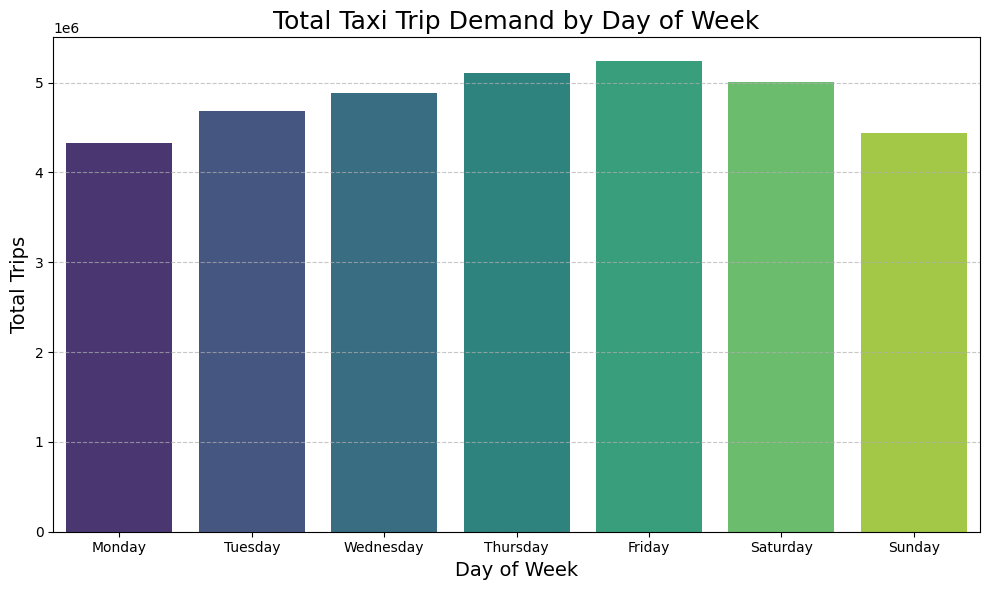

In [14]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_avg = df_train.groupby('day_name').size().reindex(day_order)

plt.figure(figsize=(10, 6)) # Increased figure size
sns.barplot(x=weekly_avg.index, y=weekly_avg.values, palette='viridis', hue=weekly_avg.index, legend=False)
plt.title('Total Taxi Trip Demand by Day of Week', fontsize=18)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Total Trips', fontsize=14)
plt.grid(axis='y', alpha=0.7, linestyle='--')
plt.tight_layout()
plt.show()


- Binary feature `is_weekend` will be critical
- Friday may require special treatment (transition day)
- Weekend model behavior will differ significantly from weekday patterns

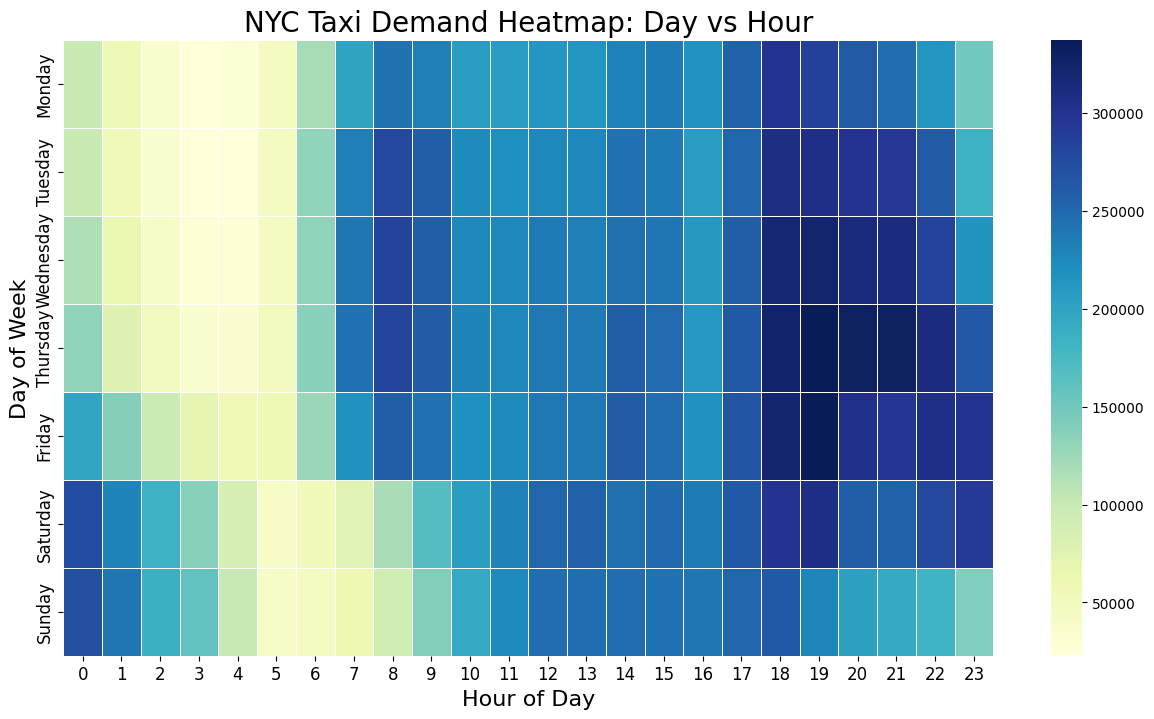

In [15]:
# Create a pivot table: Rows = Days, Columns = Hours
pivot_table = df_train.groupby(['day_name', 'hour']).size().unstack()
pivot_table = pivot_table.reindex(day_order)

plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=False, fmt="d", linewidths=.5)
plt.title('NYC Taxi Demand Heatmap: Day vs Hour', fontsize=20)
plt.xlabel('Hour of Day', fontsize=16)
plt.ylabel('Day of Week', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.savefig(os.path.join(figures_path, "day_hour_heatmap.svg"), format="svg", bbox_inches='tight')
plt.show()

* Peak Demand Hours: We can observe consistently high demand during rush hours on weekdays (e.g., 7 AM - 9 AM and 5 PM - 7 PM), aligning with typical commuting patterns. There's also a significant surge in demand during late evenings and early nights (e.g., 6 PM - 11 PM) throughout the week, especially peaking on Friday and Saturday nights, likely due to social activities and nightlife.

* Peak Demand Days: Fridays and Saturdays generally show the highest overall demand, extending into late hours. This is characteristic of weekend leisure and social activities.

* Lower Demand Hours: The earliest hours of the morning (1 AM - 5 AM) on weekdays typically show the lowest demand, as most people are asleep or public transport is less busy. However, there's still some activity, particularly on weekend early mornings when people might be returning from late-night outings.

* Daytime Demand: Weekday daytime hours (e.g., 9 AM - 4 PM) show moderate to high demand, consistent with business travel, appointments, and general errands.


We need to add a `day_of_week` feature to capture this relationship

In [16]:
import folium
from folium.plugins import HeatMap

# 1. Create a base map centered on NYC
nyc_map = folium.Map(location=[40.730610, -73.935242], zoom_start=11, tiles='cartodbpositron')

# 2. Extract Lat/Long for Heatmap
# Format: [[lat, lon], [lat, lon], ...]
heat_data = df_sample[['pickup_latitude', 'pickup_longitude']].sample(100000).values.tolist()

# 3. Add Heatmap layer
HeatMap(heat_data, radius=7, blur=5, min_opacity=0.5).add_to(nyc_map)

# 4. Display map
nyc_map

Output hidden; open in https://colab.research.google.com to view.

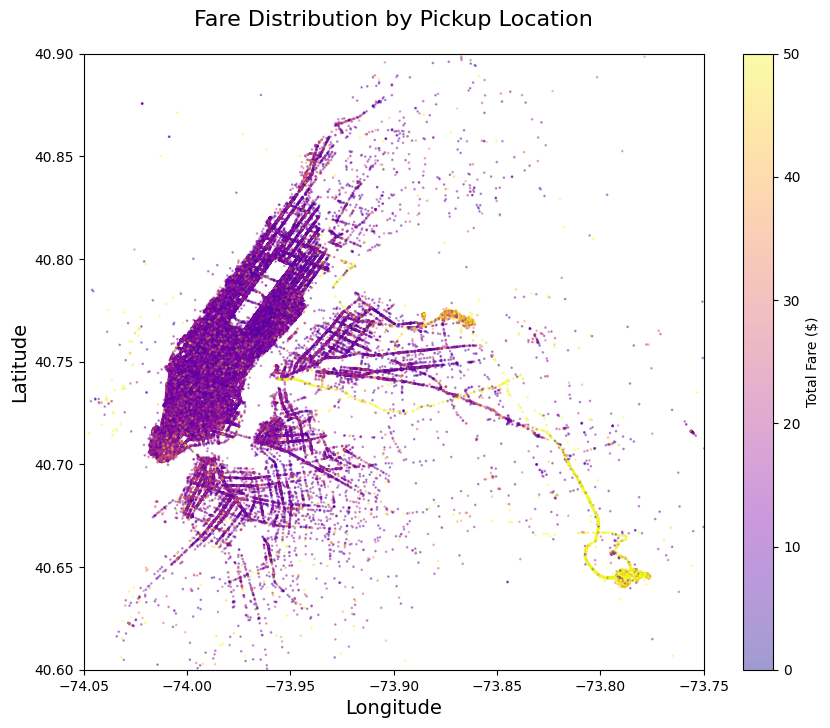

In [17]:
# Create a plot showing average total_amount based on pickup location
plt.figure(figsize=(10, 8)) # Adjusted figure size for better aspect ratio
# We use 'c' to color by total_amount.
# vmin/vmax caps the color scale so one $500 trip doesn't ruin the plot
plt.scatter(df_sample['pickup_longitude'], df_sample['pickup_latitude'],
            c=df_sample['total_amount'], cmap='plasma', s=0.8, alpha=0.4, # Changed cmap to 'plasma', increased s, decreased alpha
            vmin=0, vmax=50)

plt.colorbar(label='Total Fare ($)')
plt.xlim(-74.05, -73.75)
plt.ylim(40.60, 40.90)
plt.title('Fare Distribution by Pickup Location', fontsize=16, pad=20) # Consistent font size
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.savefig(os.path.join(figures_path, "pick_fare.png"), dpi=300, bbox_inches='tight')
plt.show()

### Pickup Location Density

**Key Findings:**
- **Manhattan Core Dominance**: Extreme concentration in Midtown + Financial District
- **Airport Hubs**: LaGuardia and JFK show as distinct high-density clusters
- **Spatial Inequality**: ~80% of demand from <20% of geographic area (visual estimate)
- **Outer Borough Sparsity**: Queens/Brooklyn show scattered, lower-density patterns

**Implications for Clustering:**
- **Variable-density clustering needed** - uniform grid would oversample empty areas
- Manhattan core may require 50-60% of clusters despite small area
- Airport zones should be distinct clusters (special operational rules)
- Consider **density-weighted K-Means** or DBSCAN alternatives

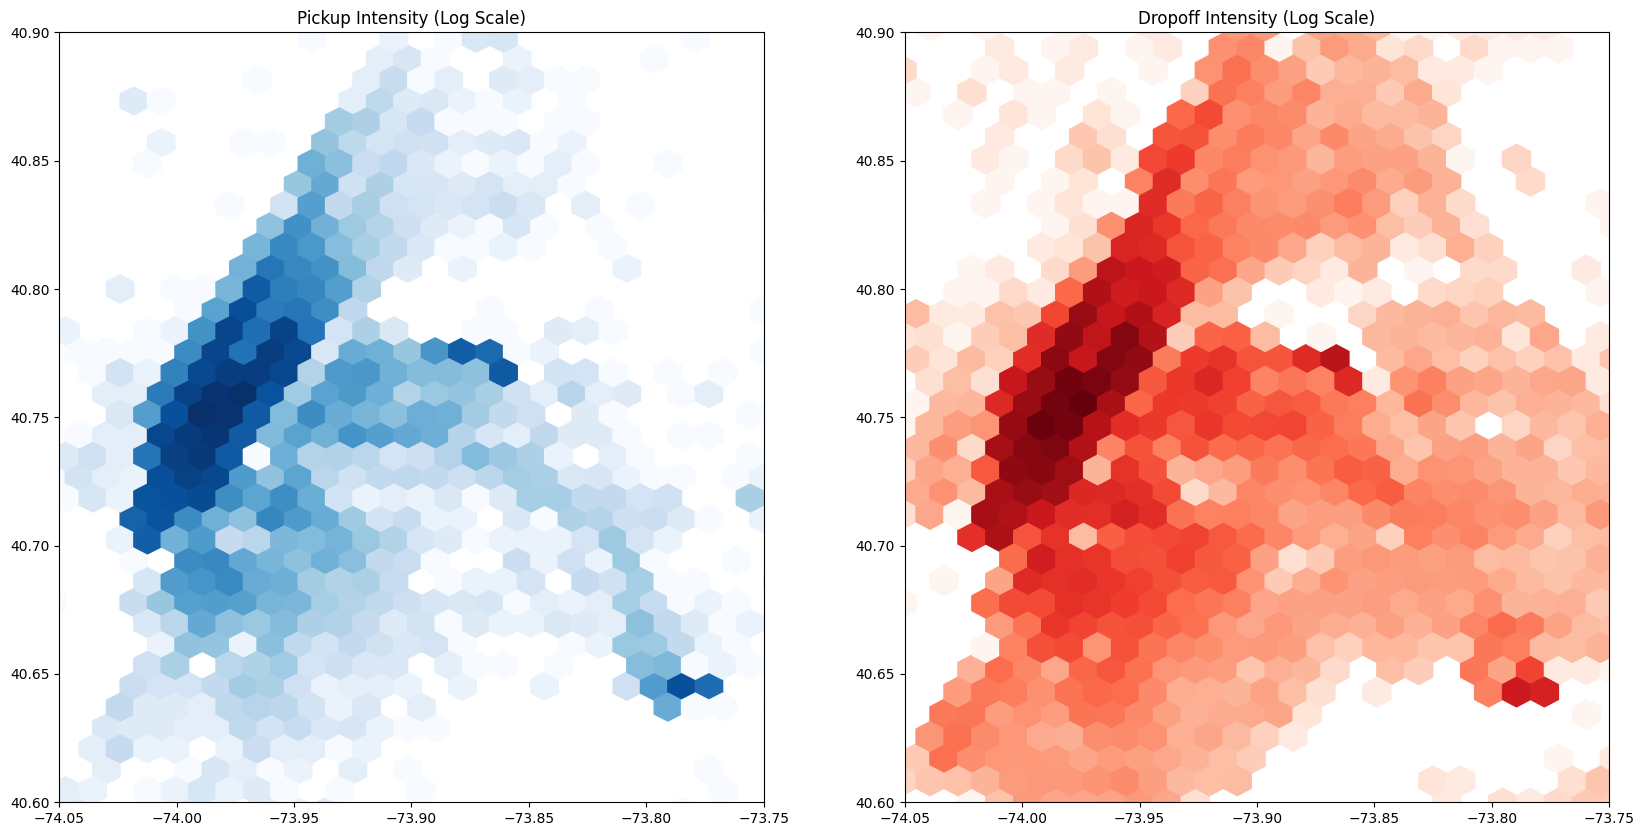

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Pickup Density
ax[0].hexbin(df_sample['pickup_longitude'], df_sample['pickup_latitude'],
             gridsize=50, bins='log', cmap='Blues')
ax[0].set_title('Pickup Intensity (Log Scale)')
ax[0].set_xlim(-74.05, -73.75)
ax[0].set_ylim(40.60, 40.90)

# Dropoff Density
ax[1].hexbin(df_sample['dropoff_longitude'], df_sample['dropoff_latitude'],
             gridsize=50, bins='log', cmap='Reds')
ax[1].set_title('Dropoff Intensity (Log Scale)')
ax[1].set_xlim(-74.05, -73.75)
ax[1].set_ylim(40.60, 40.90)

plt.show()

In [19]:
def get_time_bucket(hour):
    if 0 <= hour < 6:
        return '1. Late Night (00-06)'
    elif 6 <= hour < 10:
        return '2. Morning Rush (06-10)'
    elif 10 <= hour < 16:
        return '3. Mid-Day (10-16)'
    elif 16 <= hour < 20:
        return '4. Evening Rush (16-20)'
    else:
        return '5. Night (20-00)'

df_sample['hour'] = df_sample['tpep_pickup_datetime'].dt.hour # Add this line to create the 'hour' column for df_sample
df_sample['time_bucket'] = df_sample['hour'].apply(get_time_bucket)

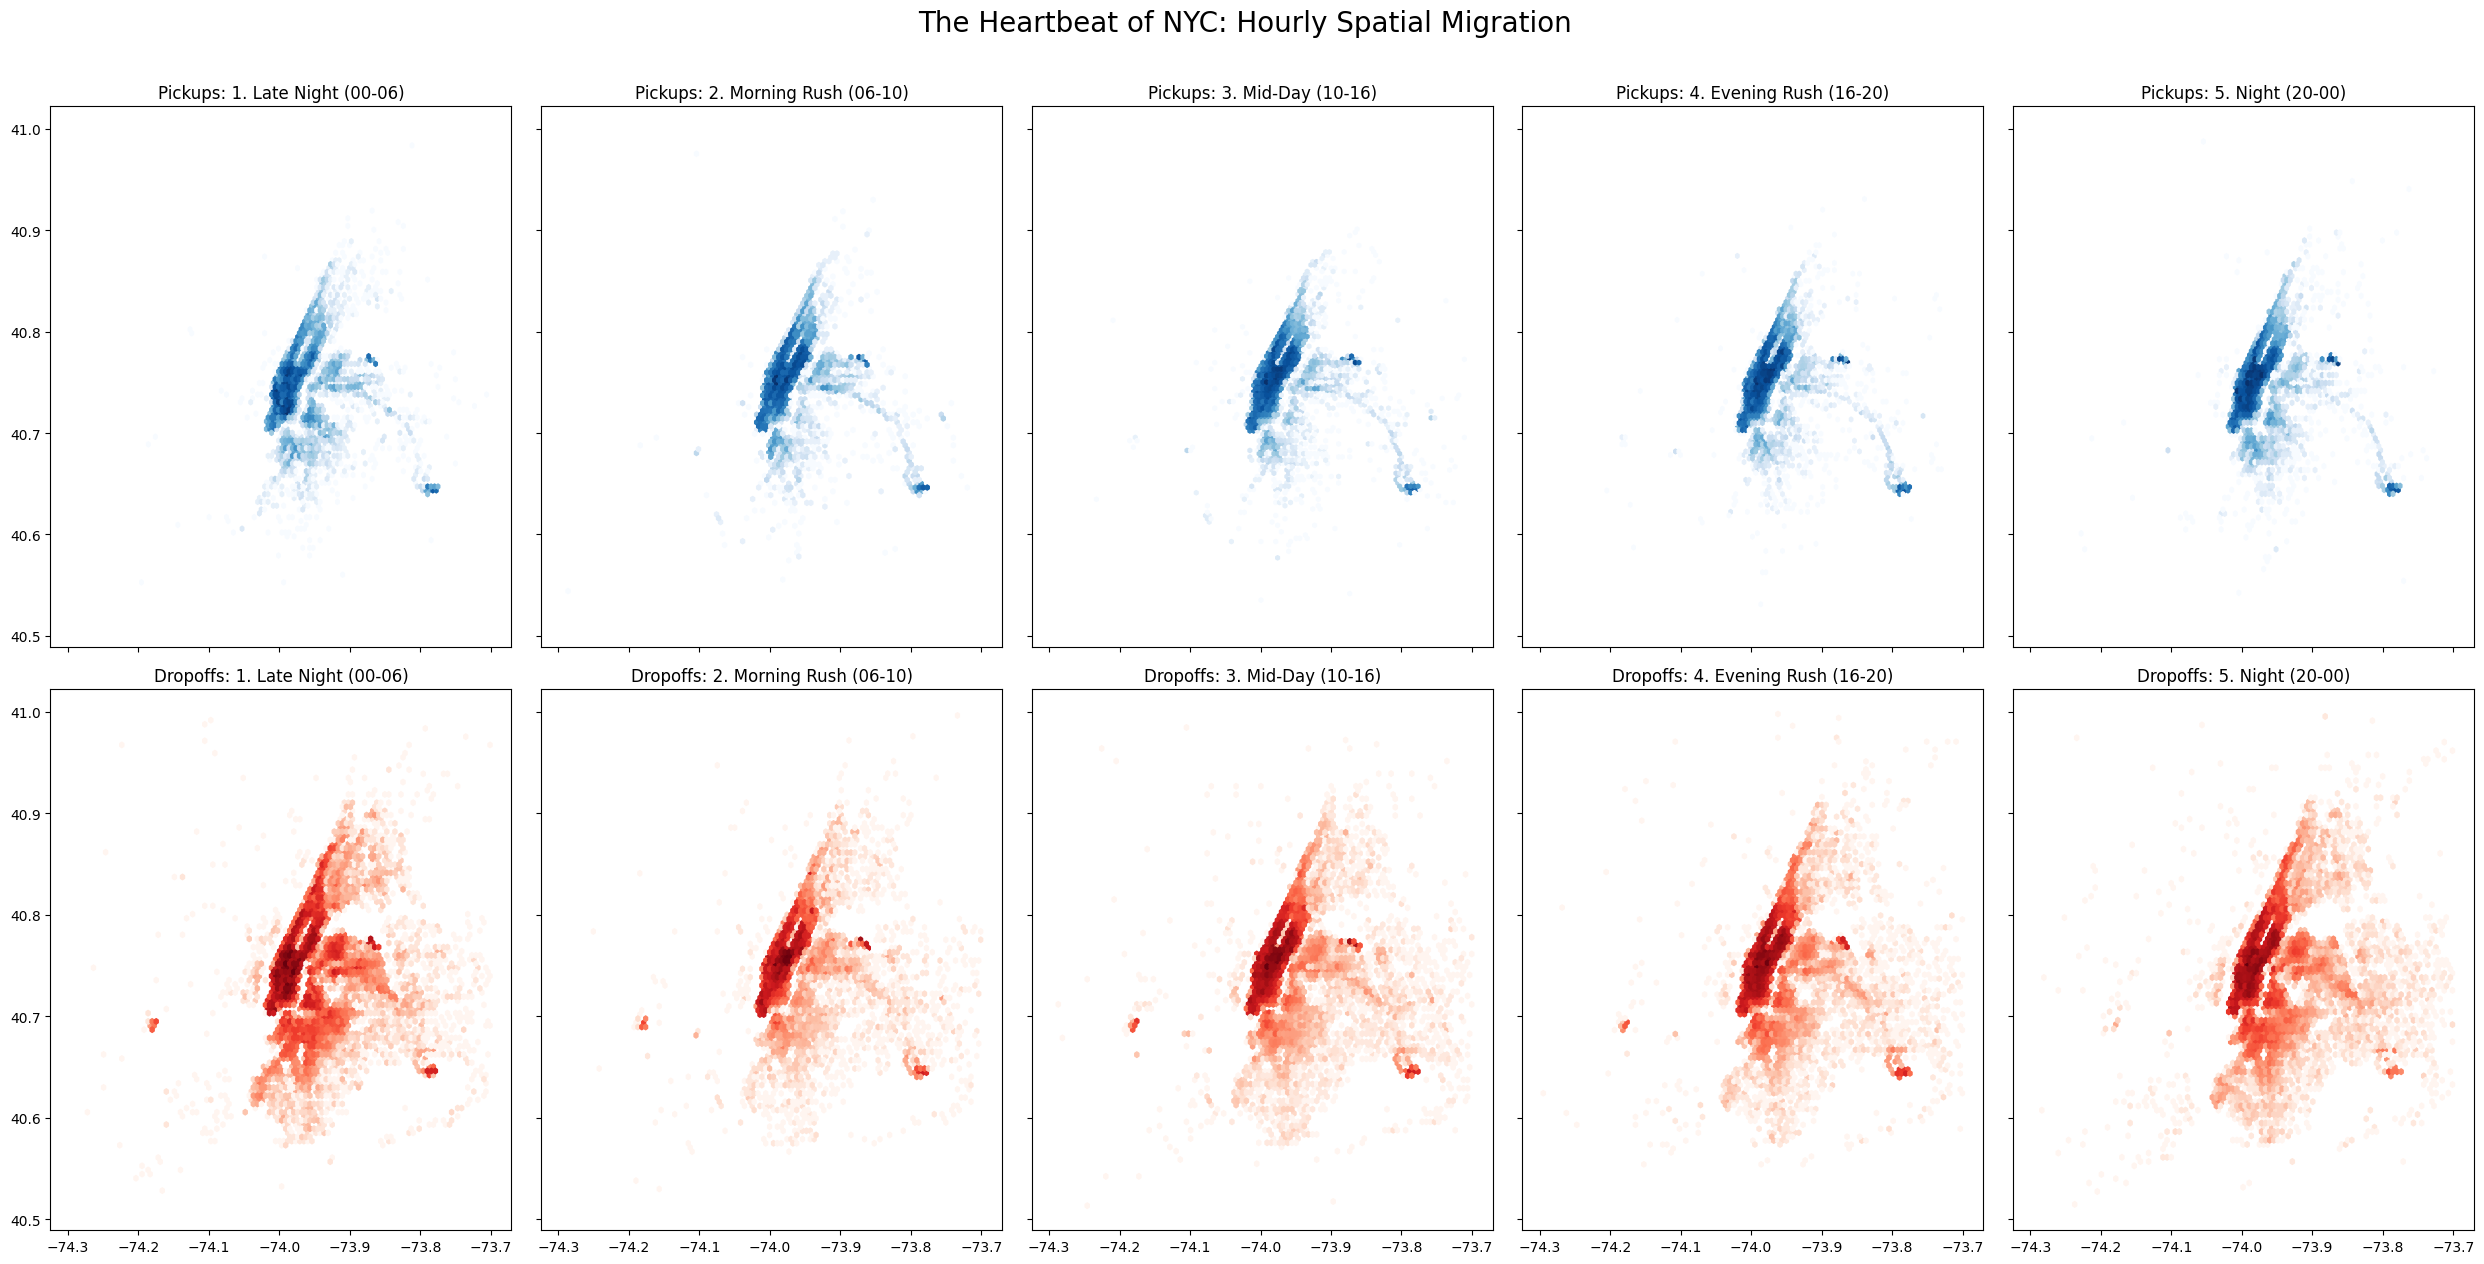

In [20]:
# Create the figure with 2 rows (Pickups, Dropoffs) and 5 columns (Time Buckets)
buckets = sorted(df_sample['time_bucket'].unique())
fig, axes = plt.subplots(2, 5, figsize=(25, 12), sharex=True, sharey=True)

for i, bucket in enumerate(buckets):
    subset = df_sample[df_sample['time_bucket'] == bucket]

    # Row 0: Pickups (Blue)
    hb1 = axes[0, i].hexbin(subset['pickup_longitude'], subset['pickup_latitude'],
                            gridsize=100, bins='log', cmap='Blues', mincnt=1)
    axes[0, i].set_title(f'Pickups: {bucket}')

    # Row 1: Dropoffs (Red)
    hb2 = axes[1, i].hexbin(subset['dropoff_longitude'], subset['dropoff_latitude'],
                            gridsize=100, bins='log', cmap='Reds', mincnt=1)
    axes[1, i].set_title(f'Dropoffs: {bucket}')
plt.tight_layout()
plt.suptitle('The Heartbeat of NYC: Hourly Spatial Migration', fontsize=20, y=1.05)
plt.show()

In [21]:
# Calculate Revenue per Minute
# We add a small constant (0.001) to avoid division by zero errors
df_train['rev_per_min'] = df_train['total_amount'] / (df_train['trip_duration_min'] + 0.1)

# Summary stats for context
print(df_train[['total_amount', 'trip_distance', 'rev_per_min']].describe())

       total_amount  trip_distance   rev_per_min
count  3.368129e+07   3.368129e+07  3.368129e+07
mean   1.562868e+01   2.905184e+00  1.321995e+00
std    1.262433e+01   3.528124e+00  2.915998e+00
min    3.100000e-01   1.000000e-02  1.312632e-03
25%    8.300000e+00   1.000000e+00  9.735100e-01
50%    1.176000e+01   1.700000e+00  1.167488e+00
75%    1.730000e+01   3.100000e+00  1.447423e+00
max    9.983000e+02   9.574000e+01  2.342600e+03


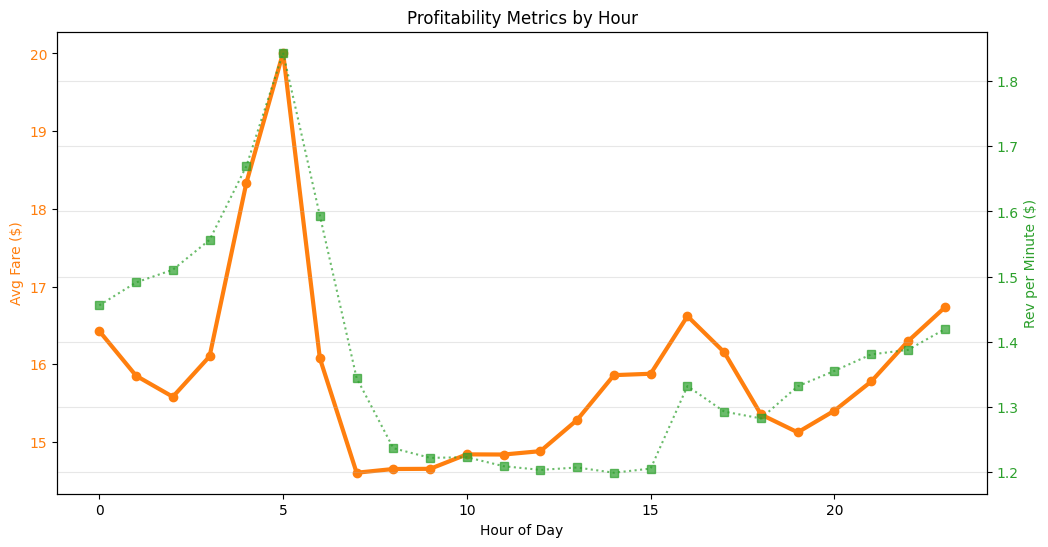

In [22]:
# Group by hour for average fare and efficiency
hourly_profit = df_train.groupby('hour').agg({
    'total_amount': 'mean',
    'rev_per_min': 'mean'
})

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Average Fare
color = 'tab:orange'
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Avg Fare ($)', color=color)
ax1.plot(hourly_profit.index, hourly_profit['total_amount'], color=color, marker='o', linewidth=3)
ax1.tick_params(axis='y', labelcolor=color)

# Plot Revenue per Minute on a second Y-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Rev per Minute ($)', color=color)
ax2.plot(hourly_profit.index, hourly_profit['rev_per_min'], color=color, marker='s', linestyle=':', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Profitability Metrics by Hour')
plt.grid(True, alpha=0.3)
plt.show()

### Revenue Per Minute Distribution

**Key Findings:**
- **Modal Efficiency**: \$0.75-1.00/min represents typical urban trips
- **High-Value Outliers**: \$3-5+/min trips (likely highway/airport runs)
- **Congestion Penalty**: Heavy left tail at <$0.50/min (gridlock scenarios)
- DeepDispatch should optimize **revenue**, not raw trip count

- **Trip count ≠ profitability** - 10 gridlocked trips < 1 airport run
- Revenue/minute reveals **quality of demand**, not just quantity
- Should inform clustering: zones with high revenue/min deserve priority

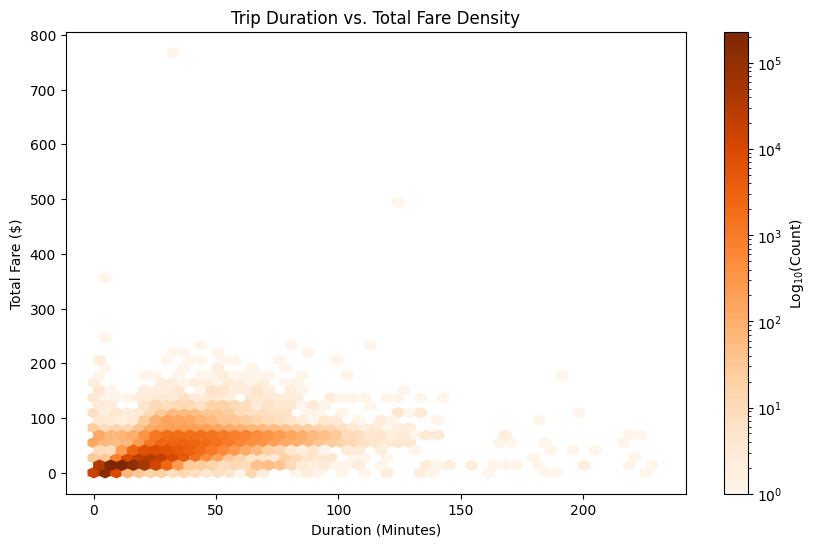

In [23]:
plt.figure(figsize=(10, 6))
plt.hexbin(df_sample['trip_duration_min'], df_sample['total_amount'],
           gridsize=50, cmap='Oranges', bins='log')
plt.colorbar(label='Log$_{10}$(Count)')
plt.xlabel('Duration (Minutes)')
plt.ylabel('Total Fare ($)')
plt.title('Trip Duration vs. Total Fare Density')
plt.show()

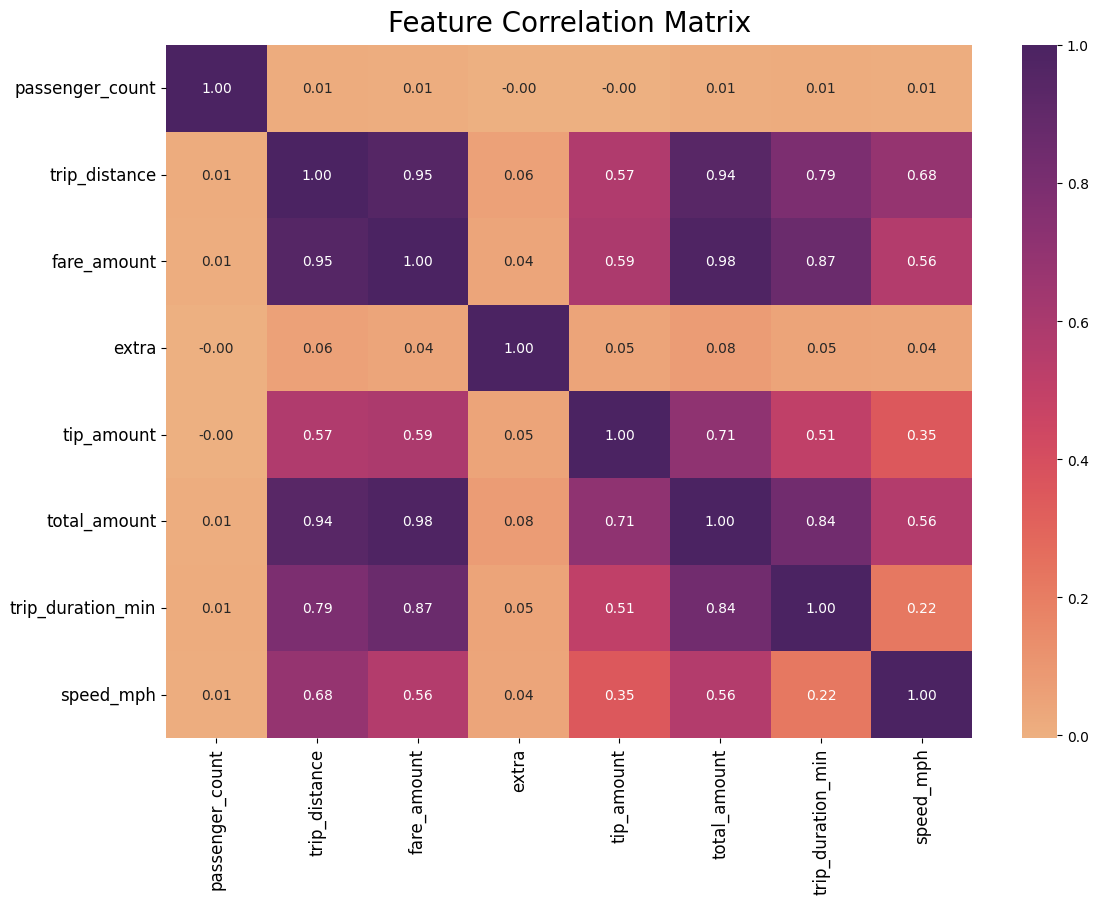

In [24]:
# Check correlations between numerical features
plt.figure(figsize=(13, 9))
corr = df_train[['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'tip_amount', 'total_amount', 'trip_duration_min', 'speed_mph']].corr()
sns.heatmap(corr, annot=True, cmap='flare', fmt=".2f")
plt.title("Feature Correlation Matrix", fontsize=20, pad=10)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.savefig(os.path.join(figures_path, "correlation_heatmap_nonagg.svg"), format="svg", bbox_inches='tight')
plt.show()